In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import re
import string
import emoji
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from langdetect import detect, LangDetectException
import contractions

# Define stop words for text cleaning
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Initialize lemmatizer for text cleaning
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to C:\Users\Akmal
[nltk_data]     Nazim\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Load the dataset
df = pd.read_csv("cyberbullying_tweets.csv")

In [3]:
# Describe the data
df.describe()
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


(47692, 2)

In [4]:
# Checking the missing data
df.isnull().sum()

,0
tweet_text,0
cyberbullying_type,0


In [5]:
df.cyberbullying_type.value_counts()

,count
cyberbullying_type,
religion,7998
age,7992
gender,7973
ethnicity,7961
not_cyberbullying,7945
other_cyberbullying,7823


In [6]:
# Clean emojis from text
def strip_emoji(text):
    return emoji.demojize(text)

# Remove punctuations, stopwords, links, mentions and new line characters
def strip_all_entities(text):
    text = re.sub(r'\r|\n', ' ', text.lower())  # Replace newline and carriage return with space, and convert to lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)  # Remove links and mentions
    text = re.sub(r'[^\x00-\x7f]', '', text)  # Remove non-ASCII characters
    banned_list = string.punctuation
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

# Clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    # Remove hashtags at the end of the sentence
    new_tweet = re.sub(r'(\s+#[\w-]+)+\s*$', '', tweet).strip()

    # Remove the # symbol from hashtags in the middle of the sentence
    new_tweet = re.sub(r'#([\w-]+)', r'\1', new_tweet).strip()

    return new_tweet

# Filter special characters such as & and $ present in some words
def filter_chars(text):
    return ' '.join('' if ('$' in word) or ('&' in word) else word for word in text.split())

# Remove multiple spaces
def remove_mult_spaces(text):
    return re.sub(r"\s\s+", " ", text)

# Function to check if the text is in English, and return an empty string if it's not
def filter_non_english(text):
    try:
        lang = detect(text)
    except LangDetectException:
        lang = "unknown"
    return text if lang == "en" else ""

# Expand contractions
def expand_contractions(text):
    return contractions.fix(text)

# Remove numbers
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

# Lemmatize words
def lemmatize(text):
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

# Remove short words
def remove_short_words(text, min_len=2):
    words = text.split()
    long_words = [word for word in words if len(word) >= min_len]
    return ' '.join(long_words)

# Replace elongated words with their base form
def replace_elongated_words(text):
    regex_pattern = r'\b(\w+)((\w)\3{2,})(\w*)\b'
    return re.sub(regex_pattern, r'\1\3\4', text)

# Remove repeated punctuation
def remove_repeated_punctuation(text):
    return re.sub(r'[\?\.\!]+(?=[\?\.\!])', '', text)

# Remove extra whitespace
def remove_extra_whitespace(text):
    return ' '.join(text.split())

def remove_url_shorteners(text):
    return re.sub(r'(?:http[s]?://)?(?:www\.)?(?:bit\.ly|goo\.gl|t\.co|tinyurl\.com|tr\.im|is\.gd|cli\.gs|u\.nu|url\.ie|tiny\.cc|alturl\.com|ow\.ly|bit\.do|adoro\.to)\S+', '', text)

# Remove spaces at the beginning and end of the tweet
def remove_spaces_tweets(tweet):
    return tweet.strip()

# Remove short tweets
def remove_short_tweets(tweet, min_words=3):
    words = tweet.split()
    return tweet if len(words) >= min_words else ""

# Function to call all the cleaning functions in the correct order
def clean_tweet(tweet):
    tweet = strip_emoji(tweet)
    tweet = expand_contractions(tweet)
    tweet = filter_non_english(tweet)
    tweet = strip_all_entities(tweet)
    tweet = clean_hashtags(tweet)
    tweet = filter_chars(tweet)
    tweet = remove_mult_spaces(tweet)
    tweet = remove_numbers(tweet)
    tweet = lemmatize(tweet)
    tweet = remove_short_words(tweet)
    tweet = replace_elongated_words(tweet)
    tweet = remove_repeated_punctuation(tweet)
    tweet = remove_extra_whitespace(tweet)
    tweet = remove_url_shorteners(tweet)
    tweet = remove_spaces_tweets(tweet)
    tweet = remove_short_tweets(tweet)
    tweet = ' '.join(tweet.split())  # Remove multiple spaces between words
    return tweet

In [7]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')
df['tweet_clean'] = [clean_tweet(tweet) for tweet in df['tweet_text']]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [8]:
df.drop_duplicates("tweet_clean", inplace=True)

In [9]:
df.cyberbullying_type.value_counts()

,count
cyberbullying_type,
religion,7916
age,7815
ethnicity,7406
gender,7281
not_cyberbullying,6102
other_cyberbullying,4931


In [10]:
# Data preprocessing
labEncoder = LabelEncoder()
labelsEncoded = labEncoder.fit_transform(df["cyberbullying_type"])

In [11]:
# Split data
train_texts, val_texts, train_labels, val_labels = train_test_split(df['tweet_clean'], labelsEncoded, test_size=0.2, random_state=42)
print((train_texts.shape, train_labels.shape, val_texts.shape, val_labels.shape))

# Reset indices
train_texts = train_texts.reset_index(drop=True)
val_texts = val_texts.reset_index(drop=True)

((33160,), (33160,), (8291,), (8291,))


In [12]:
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, return_tensors='pt', max_length=self.max_length, padding='max_length', truncation=True)
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label)
        }

In [13]:
# Create datasets and dataloaders
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer=tokenizer, max_length=128)
val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer=tokenizer, max_length=128)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [14]:
class BERTClassifier(nn.Module):
    def __init__(self, bert_model_name, num_classes):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name, output_attentions=True)  # Enable attention output
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        x = self.dropout(pooled_output)
        logits = self.fc(x)
        return logits, outputs.attentions  # Return attention weights


In [15]:
# Initialize model and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERTClassifier('bert-base-uncased', num_classes=6).to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_dataloader) * 10
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [19]:
def train(model, data_loader, optimizer, scheduler, device):
    model.train()
    for batch in data_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # Ensure labels are of type torch.long
        labels = labels.clone().detach().to(device)

        outputs, _ = model(input_ids=input_ids, attention_mask=attention_mask)  # Unpack tuple
        labels = labels.long()
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()


In [20]:
def evaluate(model, data_loader, device):
    model.eval()
    predictions = []
    actual = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs, _ = model(input_ids=input_ids, attention_mask=attention_mask)  # Unpack tuple
            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().tolist())
            actual.extend(labels.cpu().tolist())
    return accuracy_score(y_true=actual, y_pred=predictions), classification_report(y_true=actual, y_pred=predictions), actual, predictions


In [21]:
# Train model
for epoch in range(5):
    print(f"Epoch {epoch+1}/5")
    train(model, train_dataloader, optimizer, scheduler, device)
    accuracy, report, actual, predictions = evaluate(model, val_dataloader, device)
    print(f"Validation Accuracy: {accuracy:.4f}")
    print(report)

Epoch 1/5
Validation Accuracy: 0.8660
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1529
           1       0.95      0.99      0.97      1486
           2       0.90      0.89      0.89      1450
           3       0.69      0.56      0.62      1258
           4       0.60      0.69      0.64       979
           5       0.95      0.97      0.96      1589

    accuracy                           0.87      8291
   macro avg       0.84      0.85      0.84      8291
weighted avg       0.87      0.87      0.86      8291

Epoch 2/5
Validation Accuracy: 0.8723
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1529
           1       0.98      0.98      0.98      1486
           2       0.88      0.91      0.89      1450
           3       0.66      0.65      0.65      1258
           4       0.65      0.61      0.63       979
           5       0.95      0.97      0.96      1589

 

In [22]:
# Save the trained model
torch.save(model.state_dict(), "cyberbullying_model.pth")
print("Model saved as cyberbullying_model.pth")

Model saved as cyberbullying_model.pth


In [23]:
# Load model (for inference, prediction, or API deployment)
model = BERTClassifier('bert-base-uncased', num_classes=6).to(device)
model.load_state_dict(torch.load("cyberbullying_model.pth", map_location=device))
model.eval()  # Set model to evaluation mode
print("Model loaded for prediction or deployment")

<ipython-input-23-99cea2aff181>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("cyberbullying_model.pth", map_location=device))


Model loaded for prediction or deployment


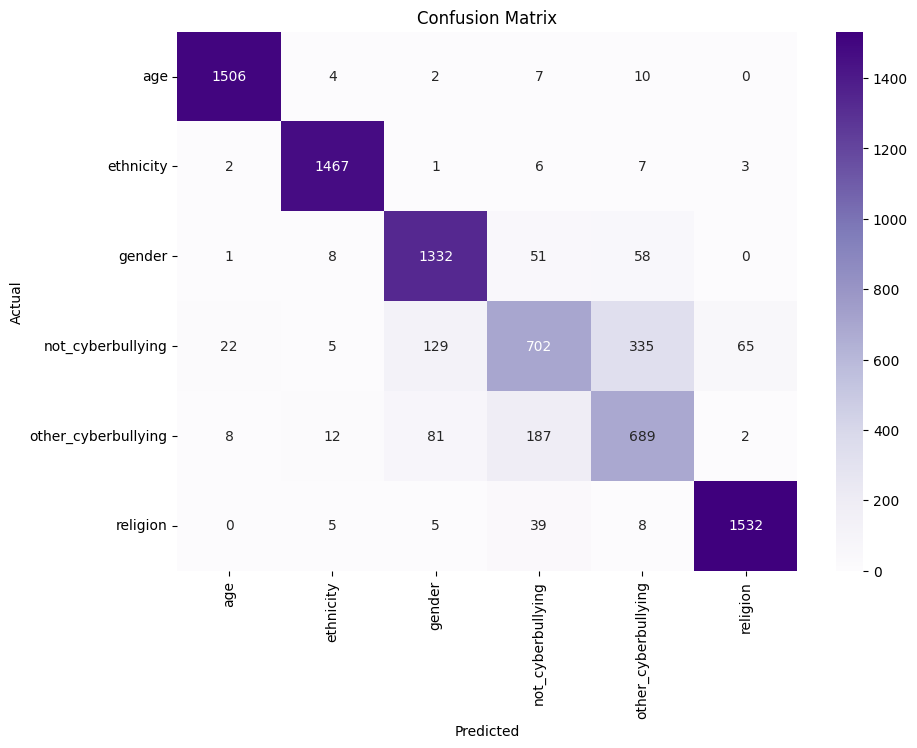

In [24]:
# Compute confusion matrix
cm = confusion_matrix(actual, predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=labEncoder.classes_, yticklabels=labEncoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [28]:
def predict_class(text, model, tokenizer, device, classes, max_length=128):
    model.eval()
    encoding = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        logits, attentions = model(input_ids=input_ids, attention_mask=attention_mask)  # Get logits and attention
        _, preds = torch.max(logits, dim=1)

    predicted_class = classes[preds.item()]

    # Convert token IDs back to words
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

    # Aggregate attention scores (use the last layer and average across heads)
    if attentions:
        last_layer_attention = attentions[-1]  # Last layer attention
        attention_scores = last_layer_attention.mean(dim=1)  # Average across heads
        word_importances = attention_scores[0, :, :].sum(dim=0).cpu().tolist()  # Aggregate across tokens
    else:
        word_importances = [0] * len(tokens)  # Fallback in case attentions are unavailable

    # Combine words with their importance scores
    words_and_importances = [(word, score) for word, score in zip(tokens, word_importances)]
    words_and_importances = sorted(words_and_importances, key=lambda x: x[1], reverse=True)  # Sort by importance

    # Filter for meaningful tokens (remove [CLS], [SEP], and padding tokens)
    influential_words = [word for word, score in words_and_importances if word not in ['[CLS]', '[SEP]', '[PAD]'] and score > 0]

    # Return the predicted class and the influential words
    return predicted_class, influential_words[:5]  # Limit to the top 5 most influential words


In [29]:
# Function to display 5 random predictions with influential words
for _ in range(5):  # Loop for 5 random samples
    random_idx = torch.randint(len(val_texts), size=(1,)).item()  # Randomly pick an index
    text, label = val_texts[random_idx], labEncoder.classes_[val_labels[random_idx]]  # Get text and its actual label

    # Get prediction and influential words
    prediction, influential_words = predict_class(text, model, tokenizer, device, labEncoder.classes_)

    # Display the results
    print("=============================================")
    print(f"Text:\n{text}")
    print(f"Actual: {label}\tPredicted: {prediction}")
    print(f"\nInfluential Words Contributing to the Predicted Class:")
    print(", ".join(influential_words))  # Display influential words in a readable format
    print("=============================================")

Text:
evidence people nazi putin troll
Actual: not_cyberbullying	Predicted: not_cyberbullying

Influential Words Contributing to the Predicted Class:
putin, people, evidence, nazi, troll
Text:
indian christian woman right property
Actual: religion	Predicted: religion

Influential Words Contributing to the Predicted Class:
right, woman, christian, indian, property
Text:
bitch nigger playing dumb fuck get kilt
Actual: ethnicity	Predicted: ethnicity

Influential Words Contributing to the Predicted Class:
##gger, dumb, playing, fuck, bitch
Text:
better alone suffer coz others
Actual: not_cyberbullying	Predicted: gender

Influential Words Contributing to the Predicted Class:
##z, others, co, suffer, better
Text:
rt muslim american feel targeted obama mention jew victim time ht http
Actual: religion	Predicted: not_cyberbullying

Influential Words Contributing to the Predicted Class:
rt, targeted, muslim, obama, jew
